### IMEC2543 - DINAMICA DE MAQUINARIA
### [Luis Alejandro Rodríguez Arenas](https://luigitoby.github.io/) Cod. 202321287
# Experiencia 1

In [1]:
import numpy as np
from numpy import deg2rad
from sympy import symbols, pi, sin, cos, lambdify, solve, linear_eq_to_matrix, simplify
from sympy.physics.mechanics import ReferenceFrame, dynamicsymbols, express
from scipy import optimize
from scipy.optimize import fsolve
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Paso 0 -  Establecer variables
Vamos a establecer las variables que necesitaremos a lo largo del ejercicio

In [2]:
theta1, theta2, theta3, x= dynamicsymbols('theta1 theta2 theta3 x')
l1, l2, l3, l4, l5, ma, mb, mc, md, g, t = symbols('l1 l2 l3 l4 l5 m_a m_b m_c m_d g, t')

FOAx, FABx, FBCx, FDCx, FOAy, FABy, FBCy, FDCy, Finx, Min, FODy, M_pris = symbols('F_OAx F_ABx F_BCx F_DCx F_OAy F_ABy F_BCy F_DCy F_inx M_in F_ODx M_pris')

N=ReferenceFrame('N')
A=N.orientnew('A','Axis',(theta1,N.z))
B=A.orientnew('B','Axis',(-theta2,N.z))
C=B.orientnew('C','Axis',(-theta3,N.z))
params={l1:0.2,l2:0.15,l3:0.6,l4:0.15,l5:0.05, g:9.8, ma:2,mb:3,mc:2, md:1}

r1 = l1*A.x
r2 = l2*B.x
r3 = l3*C.x
r4 = -l5*N.y - x*N.x

eqLoop = r1 + r2 + r3 + r4

eqParams = eqLoop.subs(params)

eq_fun = lambdify(
    [theta1, theta2, theta3, x],
    [eqParams.dot(N.x), eqParams.dot(N.y)]
)

display(eqLoop)
display(eqParams)
display([eqParams.dot(N.x), eqParams.dot(N.y)])

- x(t)*N.x - l5*N.y + l1*A.x + l2*B.x + l3*C.x

- x(t)*N.x - 0.05*N.y + 0.2*A.x + 0.15*B.x + 0.6*C.x

[0.6*(sin(theta1(t))*sin(theta2(t)) + cos(theta1(t))*cos(theta2(t)))*cos(theta3(t)) - 0.6*(-sin(theta1(t))*cos(theta2(t)) + sin(theta2(t))*cos(theta1(t)))*sin(theta3(t)) - x(t) + 0.15*sin(theta1(t))*sin(theta2(t)) + 0.15*cos(theta1(t))*cos(theta2(t)) + 0.2*cos(theta1(t)),
 -0.6*(sin(theta1(t))*sin(theta2(t)) + cos(theta1(t))*cos(theta2(t)))*sin(theta3(t)) + 0.6*(sin(theta1(t))*cos(theta2(t)) - sin(theta2(t))*cos(theta1(t)))*cos(theta3(t)) + 0.15*sin(theta1(t))*cos(theta2(t)) + 0.2*sin(theta1(t)) - 0.15*sin(theta2(t))*cos(theta1(t)) - 0.05]

# Paso 1  - FK
Como hemos visto en clase el paso 1 es realizar el FK del mecanísmo, pues este nos permitirá en el futuro determinar la posición final del efector daondole los valores de valores de $\theta$, $\dot{\theta}$ y $\dot{\theta}$ 

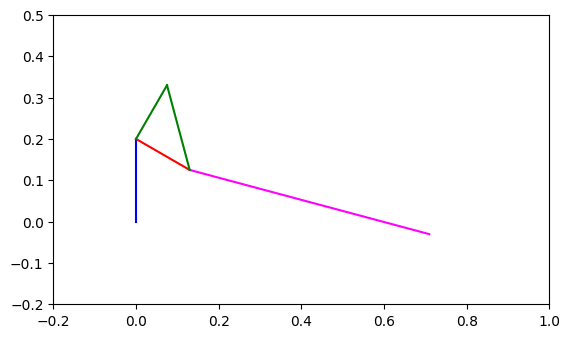

In [3]:
points={'O':0*N.x,'P':r1,'Q':r1+r2,'R':r1+r2+r3,'S':r1+l4*B.y}
points_fun={k:lambdify([theta1,theta2,theta3,x],[v.dot(N.x).subs(params),v.dot(N.y).subs(params)]) for k,v in points.items()}

def plotMechanism(joint_values,ax=None):    
    O=points_fun['O'](*joint_values) # Operador de unpacking, es decir, toma la lista de joint_values y los pasa como argumentos a la función de cada punto
    P=points_fun['P'](*joint_values)
    Q=points_fun['Q'](*joint_values)
    R=points_fun['R'](*joint_values)
    S=points_fun['S'](*joint_values)
    if ax is None:
        ax=plt.figure().add_subplot(111)
    ax.plot([O[0],P[0]], [O[1],P[1]], 'BLUE')
    ax.plot([P[0],Q[0]], [P[1],Q[1]], 'red')
    ax.plot([Q[0],R[0]], [Q[1],R[1]], 'magenta')
    ax.plot([P[0],S[0]], [P[1],S[1]], 'green')
    ax.plot([Q[0],S[0]], [Q[1],S[1]], 'green')
    ax.set_aspect('equal')
    ax.set_xlim(-0.2,1.0)
    ax.set_ylim(-0.2,0.5)

# Chekeo rápido para ver si funciona la función de plot
plotMechanism([np.deg2rad(90),np.deg2rad(120),np.deg2rad(-15),0.4])


In [4]:
def FK(q, z0=None, check=True):
    theta1, x = q

    if z0 is None:
        z0 = [np.deg2rad(45), np.deg2rad(20)]

    fsolve_fun = lambda z: eq_fun(theta1, z[0], z[1], x)
    z, info, ier, msg = fsolve(fsolve_fun, z0, full_output=True)
    
    # print("ier:", ier)
    # print("msg:", msg)
    # print("residuo:", info["fvec"])
    
    if check and ier != 1:
        raise RuntimeError(f"FK no convergió: {msg}")

    return z

-0.5211770909891477 1.8252064402193322


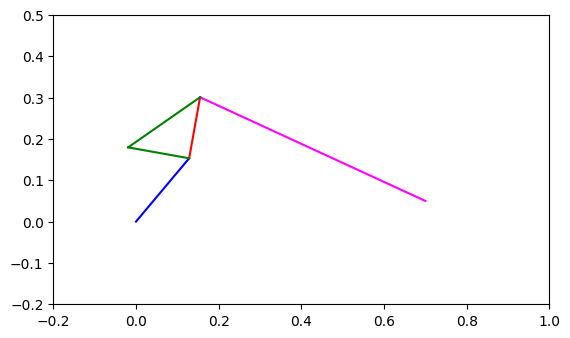

In [5]:
def drawFK(theta1, x):
    theta2, theta3 = FK([theta1, x])
    plotMechanism([theta1, theta2, theta3, x])
    print(theta2, theta3)
drawFK(np.deg2rad(50), 0.7)

# Paso 2 - Dinámica Inversa
En dinámica las incognitas son los momentos y fuerzas, por la cantidad de cuerpos (4) podemos entonces encontar 12 ecuaciones en el sistema, las cuales tenemos que escribir.

In [6]:
points={'O':0*N.x,'P':r1,'Q':r1+r2,'R':r1+r2+r3,'S':r1+l4*B.y}

com = {'A': r1/2, 
       'B': r1+(l2/3)*B.x+(l4/3)*B.y, 
       'C': r1+r2+(r3/2), 
       'D': r1+r2+r3 # Asumo que este es puntual
       }


acc_old = {
    'A': com['A'].diff(t, N).diff(t, N),
    'B': com['B'].diff(t, N).diff(t, N),
    'C': com['C'].diff(t, N).diff(t, N),
    'D': com['D'].diff(t, N).diff(t, N)

}

acc = {
    k: v.express(N).diff(t, N).diff(t, N)
    for k, v in com.items()
}

weights = {
    'A': -ma*g*N.y,
    'B': -mb*g*N.y,
    'C': -mc*g*N.y,
    'D': -md*g*N.y
}

inertia_G = {
    'A': (1/12)*ma*l1**2,
    'B': (1/18)*mb*(l2**2 + l4**2),  # triángulo plano (aprox razonable)
    'C': (1/12)*mc*l3**2,
    'D': 0
}

alpha = {
    'A': A.ang_acc_in(N).dot(N.z),
    'B': B.ang_acc_in(N).dot(N.z),
    'C': C.ang_acc_in(N).dot(N.z),
    'D': 0
}



In [7]:
C.ang_acc_in(N).dot(N.z)

Derivative(theta1(t), (t, 2)) - Derivative(theta2(t), (t, 2)) - Derivative(theta3(t), (t, 2))

In [8]:
FOA = FOAx*N.x + FOAy*N.y
FAB = FABx*N.x + FABy*N.y
FBC = FBCx*N.x + FBCy*N.y
FDC = FDCx*N.x + FDCy*N.y

r_GA_O = points['O'] - com['A']
r_GA_P = points['P'] - com['A']

r_GB_P = points['P'] - com['B']
r_GB_Q = points['Q'] - com['B']

r_GC_Q = points['Q'] - com['C']
r_GC_R = points['R'] - com['C']

r_GD_R = points['R'] - com['D']

In [9]:
# Cuerpo A
eqFAx = FOAx - FABx - ma * acc['A'].dot(N.x)
eqFAy = FOAy - FABy + weights['A'].dot(N.y) - ma * acc['A'].dot(N.y)
eqMA = Min + r_GA_O.cross(FOA).dot(N.z) + r_GA_P.cross(-FAB).dot(N.z) - inertia_G['A'] * alpha['A']
# Cuerpo B
eqFBx = FABx -FBCx - mb * acc['B'].dot(N.x)
eqFBy = FABy -FBCy + weights['B'].dot(N.y) - mb * acc['B'].dot(N.y)
eqMB = r_GB_P.cross(FAB).dot(N.z) + r_GB_Q.cross(-FBC).dot(N.z) - inertia_G['B'] * alpha['B']

# Cuerpo C
eqFCx = FBCx + FDCx - mc * acc['C'].dot(N.x)
eqFCy = FBCy + FDCy + weights['C'].dot(N.y) - mc * acc['C'].dot(N.y)
eqMC = r_GC_Q.cross(FBC).dot(N.z) + r_GC_R.cross(FDC).dot(N.z) - inertia_G['C'] * alpha['C']

# Cuerpo D
eqFDx = Finx -FDCx - md * acc['D'].dot(N.x)
eqFDy = FODy -FDCy + weights['D'].dot(N.y) - md * acc['D'].dot(N.y)
eqMD = M_pris + r_GD_R.cross(-FDC).dot(N.z) - inertia_G['D'] * alpha['D'] # La verdad no importa mucho



In [10]:
eqList = [
    eqFAx, eqFAy, eqMA,
    eqFBx, eqFBy, eqMB,
    eqFCx, eqFCy, eqMC,
    eqFDx, eqFDy, eqMD
]


In [11]:
unknowns = [
    FOAx, FOAy,
    FABx, FABy,
    FBCx, FBCy,
    FDCx, FDCy,
    FODy, Finx,
    Min, M_pris
]

In [12]:
FF, bf = linear_eq_to_matrix(eqList, unknowns)

In [13]:
FF.subs(params)

Matrix([
[                 1,                   0,                                                                                                                                                -1,                                                                                                                                                  0,                                                                                                                                                                        0,                                                                                                                                                                         0,                                                                                                                                                                       0,                                                                                                                                                 

In [14]:
bf.subs(params)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [15]:
FF.shape, bf.shape


((12, 12), (12, 1))

# Paso 2.1 - Dinámica Inversa + FK
Vamos a resolver para las incognitas, pero debemos primero calcular los theetas

In [16]:
dtheta1 = theta1.diff()
dtheta2 = theta2.diff()
dtheta3 = theta3.diff()

ddtheta1 = theta1.diff(t,2)
ddtheta2 = theta2.diff(t,2)
ddtheta3 = theta3.diff(t,2)

dx = x.diff()
ddx = x.diff(t,2)


In [17]:
start_angle = deg2rad(50)
end_angle = deg2rad(75)
dtheta1_val = 3
tiempo = (end_angle - start_angle) / dtheta1_val

tt = np.linspace(0,tiempo,100)

theta1_val = np.linspace(start_angle, end_angle, 100)

x_val = 0.7+.005*np.sin(5*tt)

# Inicializamos resultados
theta2_val = []
theta3_val = []

# Semilla inicial
# z0_current = [np.deg2rad(-50), np.deg2rad(20)]
z0_current = [-0.5, 2]

for i in range(len(tt)):
    theta1_i = theta1_val[i]
    x_i = x_val[i]

    try:
        # Llamamos a FK con z0 actualizado
        z_next = FK([theta1_i, x_i], z0=z0_current)
    except RuntimeError as e:
        print(f"No convergió en i={i}, theta1={theta1_i:.3f}, x={x_i:.3f}")
        # Opcional: usar z0 anterior como "fallback"
        z_next = z0_current

    # Guardamos resultado
    theta2_val.append(z_next[0])
    theta3_val.append(z_next[1])

    # Actualizamos z0 para la siguiente iteración
    z0_current = z_next

theta2_val = np.array(theta2_val)
theta3_val = np.array(theta3_val)

In [18]:
for i in range(5):
    print(f"{i}: theta1={theta1_val[i]:.3f}, x={x_val[i]:.3f}, theta2={theta2_val[i]:.3f}, theta3={theta3_val[i]:.3f}")


0: theta1=0.873, x=0.700, theta2=-0.521, theta3=1.825
1: theta1=0.877, x=0.700, theta2=-0.511, theta3=1.820
2: theta1=0.881, x=0.700, theta2=-0.500, theta3=1.814
3: theta1=0.886, x=0.700, theta2=-0.490, theta3=1.809
4: theta1=0.890, x=0.700, theta2=-0.479, theta3=1.804


In [19]:
# Asegurarte de que los resultados están en arrays
'''
fig, ax = plt.subplots(figsize=(6,6))

def update(i):
    ax.clear()
    # plotMechanism recibe [theta1, theta2, theta3, x]
    plotMechanism([theta1_val[i], theta2_val[i], theta3_val[i], x_val[i]], ax)
    ax.set_title(f"t={tt[i]:.2f} s - Frame {i}")
    ax.set_aspect('equal')
    
anim = animation.FuncAnimation(fig, update, frames=len(tt), repeat=False, interval=100)

# Mostrar como animación JS
HTML(anim.to_jshtml())

'''


'\nfig, ax = plt.subplots(figsize=(6,6))\n\ndef update(i):\n    ax.clear()\n    # plotMechanism recibe [theta1, theta2, theta3, x]\n    plotMechanism([theta1_val[i], theta2_val[i], theta3_val[i], x_val[i]], ax)\n    ax.set_title(f"t={tt[i]:.2f} s - Frame {i}")\n    ax.set_aspect(\'equal\')\n\nanim = animation.FuncAnimation(fig, update, frames=len(tt), repeat=False, interval=100)\n\n# Mostrar como animación JS\nHTML(anim.to_jshtml())\n\n'

In [20]:
theta1_val = np.linspace(start_angle, end_angle, 100)
x_val = 0.7+.005*np.sin(5*tt)


dtheta1_val = np.full(100, 3)
dtheta2_val = np.gradient(theta2_val, tt, edge_order=2)
dtheta3_val = np.gradient(theta3_val, tt, edge_order=2)
dx_val = np.gradient(x_val, tt, edge_order=2)

ddtheta1_val = np.zeros(100)
ddtheta2_val = np.gradient(dtheta2_val, tt, edge_order=2)
ddtheta3_val = np.gradient(dtheta3_val, tt, edge_order=2)
ddx_val = np.gradient(dx_val, tt, edge_order=2)

In [21]:
# Vector de posiciones
q_list = np.column_stack((theta1_val, theta2_val, theta3_val, x_val))

# Vector de velocidades
q_dot_list = np.column_stack((
    np.full_like(theta1_val, 3.0),  # theta1 constante
    dtheta2_val,
    dtheta3_val,
    dx_val
))

# Vector de aceleraciones
q_ddot_list = np.column_stack((
    np.zeros_like(theta1_val),  # ddtheta1 = 0
    ddtheta2_val,
    ddtheta3_val,
    ddx_val
))


In [22]:
# Sustituir valores numéricos (incluyendo thetas)
FF_num = FF.subs(params)
bf_num = bf.subs(params)

# Resolver sistema lineal
sol = FF_num.LUsolve(bf_num)

# Asociar resultados con incógnitas
solution_dict = dict(zip(unknowns, sol))

solution_dict


{F_OAx: -1.2*(sin(theta1(t))*sin(theta2(t)) + cos(theta1(t))*cos(theta2(t)))*sin(theta3(t))*Derivative(theta3(t), (t, 2)) - 1.2*(sin(theta1(t))*sin(theta2(t)) + cos(theta1(t))*cos(theta2(t)))*cos(theta3(t))*Derivative(theta3(t), t)**2 + 1.2*(-sin(theta1(t))*cos(theta2(t)) + sin(theta2(t))*cos(theta1(t)))*sin(theta3(t))*Derivative(theta3(t), t)**2 - 1.2*(-sin(theta1(t))*cos(theta2(t)) + sin(theta2(t))*cos(theta1(t)))*cos(theta3(t))*Derivative(theta3(t), (t, 2)) - 2.4*(-sin(theta1(t))*sin(theta2(t))*Derivative(theta1(t), t) + sin(theta1(t))*sin(theta2(t))*Derivative(theta2(t), t) - cos(theta1(t))*cos(theta2(t))*Derivative(theta1(t), t) + cos(theta1(t))*cos(theta2(t))*Derivative(theta2(t), t))*cos(theta3(t))*Derivative(theta3(t), t) - 2.4*(-sin(theta1(t))*cos(theta2(t))*Derivative(theta1(t), t) + sin(theta1(t))*cos(theta2(t))*Derivative(theta2(t), t) + sin(theta2(t))*cos(theta1(t))*Derivative(theta1(t), t) - sin(theta2(t))*cos(theta1(t))*Derivative(theta2(t), t))*sin(theta3(t))*Derivative

In [23]:
solution_dict[Min]

Min_fin = lambdify([theta1, theta2, theta3, x, dtheta1, dtheta2, dtheta3, dx, ddtheta1, ddtheta2, ddtheta3, ddx], solution_dict[Min])

Min_fin(theta1_val[0], theta2_val[0], theta3_val[0], x_val[0], dtheta1_val[0], dtheta2_val[0], dtheta3_val[0], dx_val[0], ddtheta1_val[0], ddtheta2_val[0], ddtheta3_val[0], ddx_val[0])

np.float64(6.048634171747814)

In [24]:
Min_time = Min_fin(
    theta1_val,
    theta2_val,
    theta3_val,
    x_val,
    dtheta1_val,
    dtheta2_val,
    dtheta3_val,
    dx_val,
    ddtheta1_val,
    ddtheta2_val,
    ddtheta3_val,
    ddx_val
)


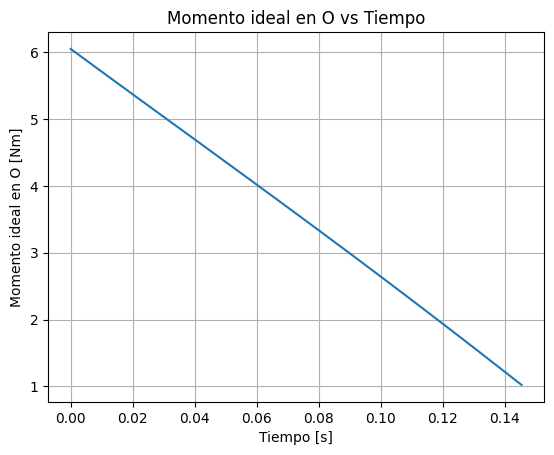

In [25]:
plt.figure()
plt.plot(tt, Min_time)
plt.xlabel("Tiempo [s]")
plt.ylabel("Momento ideal en O [Nm]")
plt.title("Momento ideal en O vs Tiempo")
plt.grid()
plt.show()


In [26]:
M_promedio = np.mean(Min_time)
print("Momento promedio =", M_promedio, "Nm")


Momento promedio = 3.5674321356920107 Nm


In [27]:
print("Torque promedio:", np.mean(Min_time))
print("Torque máximo:", np.max(Min_time))
print("Torque mínimo:", np.min(Min_time))


Torque promedio: 3.5674321356920107
Torque máximo: 6.048634171747814
Torque mínimo: 1.0231565971974887


In [28]:
# Overide para ver si directa si hace algo con su vida
# M_promedio = 1
# En efecto cambiar este valor cambia nuestra dinámica directa. Gennnnnnnnnnnnnnnnnnnial

# Paso 3 - Dinámica Directa

In [29]:
eqLoopdot = eqLoop.diff(t, N)
eqLoopddot = eqLoopdot.diff(t, N)

eqVel = [
    eqLoopdot.dot(N.x),
    eqLoopdot.dot(N.y)
]

eqVelParams = [expr.subs(params) for expr in eqVel]

eq_vel_fun = lambdify(
    [theta1, theta2, theta3, x,
     theta1.diff(t), theta2.diff(t), theta3.diff(t), x.diff(t)],
    eqVelParams
)

eqAcc = [
    eqLoopddot.dot(N.x),
    eqLoopddot.dot(N.y)
]

eqAccParams = [expr.subs(params) for expr in eqAcc]

eq_acc_fun = lambdify(
    [
        theta1, theta2, theta3, x,
        theta1.diff(t), theta2.diff(t), theta3.diff(t), x.diff(t),
        theta1.diff(t,2), theta2.diff(t,2), theta3.diff(t,2), x.diff(t,2)
    ],
    eqAccParams
)



In [30]:
def FA(theta1_val, theta2_val, theta3_val, x_val,
       dtheta1_val, dtheta2_val, dtheta3_val, dx_val,
       ddtheta1_val, ddx_val,
       z0=None):

    if z0 is None:
        z0 = [0.0, 0.0]

    def acc_eq(z):
        ddtheta2_val, ddtheta3_val = z

        return eq_acc_fun(
            theta1_val, theta2_val, theta3_val, x_val,
            dtheta1_val, dtheta2_val, dtheta3_val, dx_val,
            ddtheta1_val, ddtheta2_val, ddtheta3_val, ddx_val
        )

    sol = fsolve(acc_eq, z0)
    return sol


In [31]:
def FV(theta1_val, theta2_val, theta3_val, x_val,
       dtheta1_val, dx_val,
       z0=None):

    if z0 is None:
        z0 = [0.0, 0.0]

    def vel_eq(z):
        dtheta2_val, dtheta3_val = z

        return eq_vel_fun(
            theta1_val, theta2_val, theta3_val, x_val,
            dtheta1_val, dtheta2_val, dtheta3_val, dx_val
        )

    sol = fsolve(vel_eq, z0)
    return sol


In [32]:
unknowns_fd = [
    FOAx, FOAy,
    FABx, FABy,
    FBCx, FBCy,
    FDCx, FDCy,
    FODy, Finx,
    ddtheta1,   # ← ahora es incógnita
    M_pris
]


In [33]:
FF_fd, bf_fd = linear_eq_to_matrix(eqList, unknowns_fd)


In [34]:
FF_fd = FF_fd.subs(params)
bf_fd = bf_fd.subs(params)


In [35]:
FF_fd_fun = lambdify(
    [theta1, theta2, theta3, x,
     dtheta1, dtheta2, dtheta3, dx,
     Min, ddtheta2, ddtheta3, ddx],
    FF_fd,
    modules="numpy"
)

bf_fd_fun = lambdify(
    [theta1, theta2, theta3, x,
     dtheta1, dtheta2, dtheta3, dx,
     Min, ddtheta2, ddtheta3, ddx],
    bf_fd,
    modules="numpy"
)


In [36]:
def dynamics(y, t):

    theta1_val = float(y[0])
    omega1_val = float(y[1])

    # Movimiento impuesto del deslizador
    x_val = 0.7 + 0.005*np.sin(5*t)
    dx_val = 0.005*5*np.cos(5*t)
    ddx_val = -0.005*25*np.sin(5*t)

    theta2_val, theta3_val = FK([theta1_val, x_val])

    dtheta2_val, dtheta3_val = FV(
        theta1_val,
        theta2_val,
        theta3_val,
        x_val,
        omega1_val,
        dx_val
    )

    A_num = FF_fd_fun(
        theta1_val, theta2_val, theta3_val, x_val,
        omega1_val, dtheta2_val, dtheta3_val, dx_val,
        M_promedio, 0.0, 0.0, ddx_val
    )

    b_num = bf_fd_fun(
        theta1_val, theta2_val, theta3_val, x_val,
        omega1_val, dtheta2_val, dtheta3_val, dx_val,
        M_promedio, 0.0, 0.0, ddx_val
    )

    A_num = np.array(A_num, dtype=float)
    b_num = np.array(b_num, dtype=float).flatten()

    sol = np.linalg.solve(A_num, b_num)

    ddtheta1_val = float(sol[10])

    ddtheta2_val, ddtheta3_val = FA(
        theta1_val,
        theta2_val,
        theta3_val,
        x_val,
        omega1_val,
        dtheta2_val,
        dtheta3_val,
        dx_val,
        ddtheta1_val,
        ddx_val
    )

    A_num = FF_fd_fun(
        theta1_val, theta2_val, theta3_val, x_val,
        omega1_val, dtheta2_val, dtheta3_val, dx_val,
        M_promedio, ddtheta2_val, ddtheta3_val, ddx_val
    )

    b_num = bf_fd_fun(
        theta1_val, theta2_val, theta3_val, x_val,
        omega1_val, dtheta2_val, dtheta3_val, dx_val,
        M_promedio, ddtheta2_val, ddtheta3_val, ddx_val
    )

    A_num = np.array(A_num, dtype=float)
    b_num = np.array(b_num, dtype=float).flatten()

    sol = np.linalg.solve(A_num, b_num)

    ddtheta1_val = float(sol[10])

    return [omega1_val, ddtheta1_val]


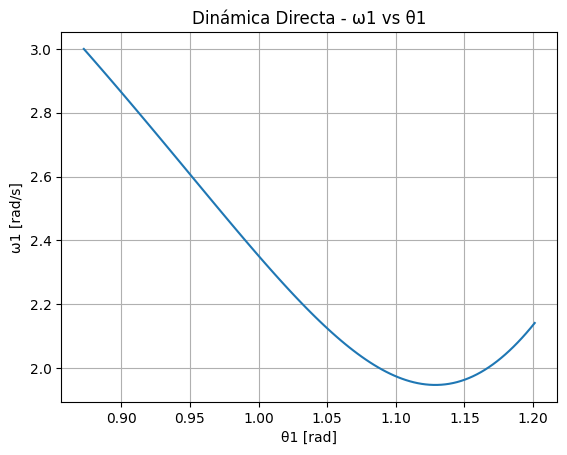

In [37]:
from scipy.integrate import odeint

y0 = [start_angle, 3.0]

t_sim = np.linspace(0, tiempo, 100)

sol_dir = odeint(dynamics, y0, t_sim)

theta1_dir = sol_dir[:,0]
omega1_dir = sol_dir[:,1]

plt.figure()
plt.plot(theta1_dir, omega1_dir)
plt.xlabel("θ1 [rad]")
plt.ylabel("ω1 [rad/s]")
plt.title("Dinámica Directa - ω1 vs θ1")
plt.grid()
plt.show()
